# Load a Python plugin

## Set up environment

We asssume a xeus-cling Conda environment with Python 3.11.

> TODO(DF): Find a way to parametrise the Python version.

#### Installing Conda

On Ubuntu, Conda can be installed by

```
curl https://repo.anaconda.com/pkgs/misc/gpgkeys/anaconda.asc | gpg --dearmor > conda.gpg
sudo install -o root -g root -m 644 conda.gpg /usr/share/keyrings/conda-archive-keyring.gpg
gpg --keyring /usr/share/keyrings/conda-archive-keyring.gpg --no-default-keyring --fingerprint 34161F5BF5EB1D4BFBBB8F0A8AEB4F8B29D82806
echo "deb [arch=amd64 signed-by=/usr/share/keyrings/conda-archive-keyring.gpg] https://repo.anaconda.com/pkgs/misc/debrepo/conda stable main" | sudo tee /etc/apt/sources.list.d/conda.list
sudo apt update
sudo apt install conda

# Next line needed in any new terminal until re-login
source /opt/conda/etc/profile.d/conda.sh
```

#### Conda Jupyter Notebook environment

```
conda create -n jupyter --yes
conda activate jupyter

# mamba is a rewrite of conda in C++ and is orders of magnitude quicker.
conda install mamba -c conda-forge --yes
# Minimum version of gcc installed that also works with xeus-cling
mamba install xeus-cling jupyterlab gcc==10.4.0 gxx==10.4.0 tox git cmake ninja conan=1.59.0 -c conda-forge --yes
```

#### Get dependencies

This uses `tox` to create a local environment under `.tox/dependencies` with OpenAssetIO and associated tools built and installed into it.

**Note**: this may take some time...

In [1]:
!python -m tox

dependencies: install_deps> python -I -m pip install openassetio-manager-bal openassetio-traitgen
dependencies: commands[0]> python get_deps.py
Cloning into 'src'...
Auto detecting your dev setup to initialize the default profile (/tmp/tmpk4pdyiih/deps/openassetio/conan/.conan/profiles/default)
CC and CXX: /opt/conda/envs/jupyter/bin/x86_64-conda-linux-gnu-gcc, /opt/conda/envs/jupyter/bin/x86_64-conda-linux-gnu-c++ 
Found gcc 10.4
gcc>=5, using the major as version

************************* WARNING: GCC OLD ABI COMPATIBILITY ***********************
 
Conan detected a GCC version > 5 but has adjusted the 'compiler.libcxx' setting to
'libstdc++' for backwards compatibility.
Your compiler is likely using the new CXX11 ABI by default (libstdc++11).

If you want Conan to use the new ABI for the default profile, run:

    $ conan profile update settings.compiler.libcxx=libstdc++11 default

Or edit '/tmp/tmpk4pdyiih/deps/openassetio/conan/.conan/profiles/default' and set compiler.libcxx=libs

#### Load Python

Load the Python available in the Conda environment this Notebook is running in.

Use xeus-cling pragma extension to add search paths and load the library.

In [2]:
#pragma cling add_library_path("$CONDA_PREFIX/lib")

In [3]:
#pragma cling load("python3.11")

#### Load OpenAssetIO library

In [4]:
#pragma cling add_include_path(".tox/dependencies/include")
#pragma cling add_library_path(".tox/dependencies/lib")

In [5]:
#pragma cling load("openassetio-python")

#### Update PYTHONPATH

We must add the OpenAssetIO Python modules to the `PYTHONPATH`.

In [6]:
#include <stdlib.h>
setenv("PYTHONPATH", ".tox/dependencies/lib/python3.11/site-packages", true);

#### Bootstrap Python

In [7]:
#include <python3.11/Python.h>
Py_Initialize();

## Define a logger

In [8]:
#include <iostream>

#include <openassetio/log/LoggerInterface.hpp>

struct Logger : openassetio::log::LoggerInterface {
  void log(Severity severity, const openassetio::Str& message) override {
      std::cout << message << "\n";
  }
};

auto logger = std::make_shared<Logger>();

## Query Python plugins

In [9]:
#include <memory>

#include <openassetio/hostApi/ManagerImplementationFactoryInterface.hpp>
#include <openassetio/python/hostApi.hpp>

const auto factory = openassetio::python::hostApi::createPythonPluginSystemManagerImplementationFactory(logger);
const openassetio::Identifiers identifiers = factory->identifiers();

identifiers

PythonPluginSystem: Searching packages for 'openassetio.manager_plugin' entry points.
PythonPluginSystem: Found entry point in plugin_package_or_module
PythonPluginSystem: Registered plug-in '<class 'openassetio_manager_bal.BasicAssetLibraryPlugin'>' from '/home/dave/workspace/cloud/assetapi/OpenAssetIO/doc/jupyter-notebooks/.tox/dependencies/lib/python3.11/site-packages/openassetio_manager_bal/__init__.py'


{ "org.openassetio.examples.manager.bal" }

## Define host interface

In [10]:
#include <openassetio/hostApi/HostInterface.hpp>

struct Host : openassetio::hostApi::HostInterface {
  openassetio::Identifier identifier() const { return "org.demo"; }
  openassetio::Str displayName() const { return "Demo Host"; }
  openassetio::InfoDictionary info() const { return {}; }
};

const auto host = std::make_shared<Host>();

## Get a manager instance

Here we pass a path to the `config.toml`, we could also use the `OPENASSETIO_DEFAULT_CONFIG` environment variable.

In [11]:
#include <openassetio/hostApi/ManagerFactory.hpp>

const auto manager = openassetio::hostApi::ManagerFactory::defaultManagerForInterface("resources/config.toml", host, factory, logger)

Loading default manager config at 'resources/config.toml'
Instantiating org.openassetio.examples.manager.bal
Loading library from '/home/dave/workspace/cloud/assetapi/OpenAssetIO/doc/jupyter-notebooks/resources/database.json'
Running with simulated query latency of 10ms
Entity reference prefix 'bal:///' provided by manager's info() dict. Subsequent calls to isEntityReferenceString will use this prefix rather than call the manager's implementation.


## Resolve some data

In [12]:
#include <openassetio/hostApi/Manager.hpp>

#include <openassetio_mediacreation/traits/content.hpp>

using openassetio_mediacreation::traits::content::LocatableContentTrait;

const openassetio::ContextPtr context = manager->createContext();

const openassetio::EntityReference ref = manager->createEntityReference("bal:///demo_project/logos/openassetio");

const auto data = manager->resolve(ref, {LocatableContentTrait::kId}, context);

std::string url = LocatableContentTrait(data).getLocation();

url

"file:///home/dave/workspace/cloud/assetapi/OpenAssetIO/doc/jupyter-notebooks/resources/OpenAssetIO_Logo-1024x212.jpg"

In [13]:
auto file_path = url.substr(7);
file_path

"/home/dave/workspace/cloud/assetapi/OpenAssetIO/doc/jupyter-notebooks/resources/OpenAssetIO_Logo-1024x212.jpg"

#### (boilerplate to render images in the notebook)

This next snippet is from the xeus-cling docs, required in order to display images in the Notebook: https://xeus-cling.readthedocs.io/en/latest/rich_display.html

In [14]:
/**
 * Modified from: https://xeus-cling.readthedocs.io/en/latest/rich_display.html
 * 
 * Why isn't this built-in ???
 */ 

#include <string>
#include <fstream>

#include "xtl/xbase64.hpp"
#include "nlohmann/json.hpp"

namespace nl = nlohmann;

namespace im
{
    struct jpg
    {
        inline jpg(const std::string& filename)
        {
            std::ifstream fin(filename, std::ios::binary);
            m_buffer << fin.rdbuf();
        }

        std::stringstream m_buffer;
    };

    nl::json mime_bundle_repr(const jpg& i)
    {
        auto bundle = nl::json::object();
        bundle["image/jpeg"] = xtl::base64encode(i.m_buffer.str());
        return bundle;
    }
}

#### Render the resolved and retrieved data

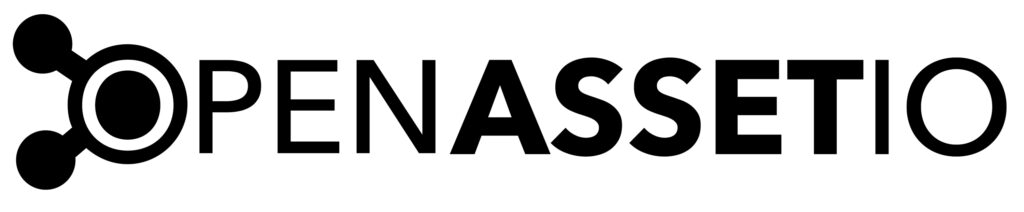

In [15]:
im::jpg logo{file_path};
logo

#### Shut down Python

In [16]:
//Py_FinalizeEx();  // TODO(DF): is this necessary in a notebook?